## Model
Cox Prosess model with latent GP intensity function is defined as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim\mathcal{GP}(K)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{1:N} \sim Cox\left(\lambda(x) = \exp(f(x))\right)$,

where $K(x_1,x_2) = \exp\left(\beta - \mathrm{softplus}({\alpha}) \sum_{d=1,2}(x_{1d} - x_{2d})^2\right)$, for $\theta=(\beta, \alpha)$.

## Import

In [1]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm, expon
from matplotlib import pyplot as plt
import time
np.random.seed(0)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Utilities

In [4]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def tf_reduce_and(ary, axis=1, keepdims=False):
    return tf.logical_not(tf.reduce_any(tf.logical_not(ary), axis=axis, keepdims=keepdims))
    
def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Data

In [5]:
def rejector(x):
    cond = tf.math.logical_and(x>=-4, x<=+4)
    cond = tf.math.logical_and(cond[:,0], cond[:,1])
    return x[cond,:]

In [6]:
def generate_data(N=10000, rejector=lambda x:x):
    K = 10
    np.random.seed(3)
    mu = np.random.randn(K*2).reshape([K,2])*2
    N0 = N
    while True:
        component = np.random.choice(np.arange(K), size=N)
        x = 0.2*np.random.randn(2*N).reshape([N,2]) + mu[component]
        x = rejector(x)
        if x.shape[0]>=N0:
            return x[:N0]
        else:
            N *= 2

## MC estimator of Lower Bound
\begin{align}
\log p(y)
&\geq \log p(y) - \mathrm{KL}[q(f_0)||p(f_0|y)] \\
&= \mathrm{E}_{q(f_0)}\log p(y|f_0) - \mathrm{KL}[q(f_0)||p(f_0)] \\
&\geq \mathrm{E}_{q(f_0)} \left[ \log p(y|f_0) - \mathrm{KL}[p(f|f_0)||p(f|f_0,y)] \right]  - \mathrm{KL}[q(f_0)||p(f_0)] \\
&\geq \mathrm{E}_{q(f_0)} \mathrm{E}_{p(f|f_0)}[\log p(y|f)] - \mathrm{KL}[q(f_0)||p(f_0)]
\end{align}

In [7]:
def ELBO(y, theta, phi, config):

    m = phi['m']
    cholS = phi['colS']
    x_i = theta['x_i']
    beta = theta['beta']
    alpha = theta['alpha']
    sp_alpha = tf.math.softplus( alpha )
    x_sampler = config['x_sampler']
    area = config['area']
    
    N = y.shape[0]
    M = m.shape[0]
    
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, 2])
        x2 = tf.reshape(x2, [1 ,n2, 2])
        return tf.exp(beta - tf.reduce_sum((x1-x2)**2, axis=2) * sp_alpha)
    
    K_ii = K(x_i, x_i) + 1e-2 * tf.eye(M, dtype=tf.float64)
    CholK_ii = tf.linalg.cholesky(K_ii)
    inv_CholK_ii = tf.linalg.inv(CholK_ii)
    inv_K_ii = tf.transpose(inv_CholK_ii)@inv_CholK_ii
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0, scale_tril=CholK_ii)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=cholS)
    u = q_u.sample(N)
    
    def sample_f(x_n):
        K_ni = K(x_n, x_i)
        K_in = tf.transpose(K_ni)
        f_n_mean = tf.linalg.einsum('ni,ij,nj->n', K_ni, inv_K_ii, u)
        f_n_var  = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(y, axis=1))
        f_n_var = tf.reshape(f_n_var, [N])
        f_n_var = f_n_var - tf.linalg.einsum('ni,ij,jn->n', K_ni, inv_K_ii, K_in)
        p_f_n = tfp.distributions.Normal(loc=f_n_mean, scale=f_n_var)
        f_n = p_f_n.sample()
        return f_n
    
    x_t = x_sampler(N)
    f_t = sample_f(x_t)
    f_n = sample_f(y)
    
    elbo = tf.reduce_sum(f_n)\
            - area * tf.reduce_mean(tf.math.exp(f_t))\
            - tfp.distributions.kl_divergence(q_u, p_u)
    return elbo

In [8]:
N = 400
x = generate_data(N, rejector)

In [9]:
x_sampler = lambda n: np.random.uniform(low=-4,high=4, size=n*2).reshape([n,2])
D = 30
phi = {
    'm': tf.Variable(np.zeros([D])),
    'colS': tf.Variable(np.eye(D, dtype=np.float64))
}
theta = {
    'x_i': tf.Variable(x_sampler(D)),
    'alpha': tf.Variable(1., dtype=tf.float64),
    'beta': tf.Variable(-1., dtype=tf.float64),
}
config = {
    'x_sampler': x_sampler,
    'area': 8*8
}

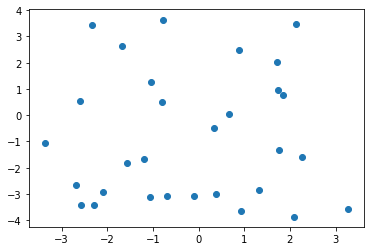

In [11]:
plt.scatter(theta['x_i'][:,0], theta['x_i'][:,1])

In [10]:
def apply_grad(param, dparam, learning_rate):
    for p, dp in zip(param.values(), dparam.values()):
        p.assign_add(learning_rate * dp)

In [12]:
for i in range(1000):
    
    with tf.GradientTape() as g:
        g.watch([theta, phi])
        elbo = ELBO(x, theta, phi, config)
    dtheta, dphi = g.gradient(elbo, [theta, phi])
    
    apply_grad(theta, dtheta, 0.05/N)
    apply_grad(phi, dphi, 0.1/N)
    
    if i%20==0:
        print('#iter: {}\t{}'.format(i,elbo.numpy()))

#iter: 0	-129.48086058156525
#iter: 20	-45.87322011020093
#iter: 40	87.72647041844999
#iter: 60	280.40214223839405
#iter: 80	376.22207873864494
#iter: 100	594.3012911042596
#iter: 120	461.98808787582817
#iter: 140	584.4104748329618
#iter: 160	482.661054142447
#iter: 180	252.2861944961546
#iter: 200	693.7400037119039
#iter: 220	564.0935080513949
#iter: 240	747.9324610451707
#iter: 260	764.5872009057982
#iter: 280	709.7938615467466
#iter: 300	694.2059810095355
#iter: 320	837.9822506528253
#iter: 340	778.1885991970096
#iter: 360	877.9926097776124
#iter: 380	947.3433979858689
#iter: 400	930.221725982628
#iter: 420	818.4436286463705
#iter: 440	934.8030527369813
#iter: 460	901.4326993735283
#iter: 480	919.3965690914484
#iter: 500	873.8172114177623
#iter: 520	954.2922968560074
#iter: 540	960.1682797651606
#iter: 560	1013.2937464566959
#iter: 580	888.3067014676398
#iter: 600	994.1174758535628
#iter: 620	921.0874875994836
#iter: 640	918.4879110761008
#iter: 660	974.9227285868562
#iter: 680	921.

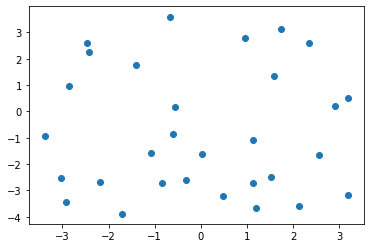

In [13]:
plt.scatter(theta['x_i'][:,0], theta['x_i'][:,1])

In [14]:
def intensity(y, theta, phi, config):

    m = phi['m']
    cholS = phi['colS']
    x_i = theta['x_i']
    beta = theta['beta']
    alpha = theta['alpha']
    sp_alpha = tf.math.softplus( alpha )
    x_sampler = config['x_sampler']
    area = config['area']
    
    N = y.shape[0]
    M = m.shape[0]
    
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, 2])
        x2 = tf.reshape(x2, [1 ,n2, 2])
        return tf.exp(beta - tf.reduce_sum((x1-x2)**2 / sp_alpha, axis=2))
    
    K_ii = K(x_i, x_i)
    CholK_ii = tf.linalg.cholesky(K_ii)
    inv_CholK_ii = tf.linalg.inv(CholK_ii)
    inv_K_ii = tf.transpose(inv_CholK_ii)@inv_CholK_ii
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0, scale_tril=CholK_ii)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=cholS)
    u = q_u.sample(N)
    
    def sample_f(x_n):
        K_ni = K(x_n, x_i)
        K_in = tf.transpose(K_ni)
        f_n_mean = tf.linalg.einsum('ni,ij,nj->n', K_ni, inv_K_ii, u)
        f_n_var  = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(y, axis=1))
        f_n_var = tf.reshape(f_n_var, [N])
        f_n_var = f_n_var - tf.linalg.einsum('ni,ij,jn->n', K_ni, inv_K_ii, K_in)
        p_f_n = tfp.distributions.Normal(loc=f_n_mean, scale=f_n_var)
        f_n = p_f_n.sample()
        return f_n
    
    x_t = x_sampler(N)
    f_t = sample_f(x_t)
    
    K_ni = K(y, x_i)
    K_in = tf.transpose(K_ni)
    f_n_mean = tf.linalg.einsum('ni,ij,j->n', K_ni, inv_K_ii, m)
    
    intensity = tf.exp(f_n_mean)
    return intensity

In [15]:
x1_heat = (np.linspace(start=-4,stop=4).reshape([1,50])*np.ones([50,1])).reshape([2500])
x2_heat = np.repeat(np.linspace(start=-4,stop=4), 50)
x_heat = np.array([x1_heat, x2_heat]).T
mean_intensity = intensity(x_heat, theta, phi, config).numpy()

In [16]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='Blues', extent=[-4,4,-4,4],origin='lower')#'viridis')
    plt.colorbar()
    plt.show()

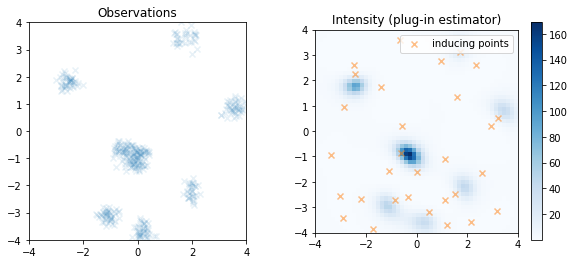

In [47]:
plt.figure(figsize=[10,4])

plt.subplot(1,2,1)
plt.title('Observations')
plt.scatter(x[:,0], x[:,1], alpha=0.1, marker='x', c='C0')
plt.xlim([-4,4])
plt.ylim([-4,4])
ax = plt.gca()
ax.set_aspect('equal')

plt.subplot(1,2,2)
plt.title('Intensity (plug-in estimator)')
plt.scatter(theta['x_i'][:,0], theta['x_i'][:,1], alpha=0.5, marker='x', c="C1")
plt.legend(['inducing points'])
heatmap2d(mean_intensity.reshape([50,50]))

In [28]:
mean_intensity.mean()*16

70.56880832365819

In [44]:
theta['beta'], theta['alpha']

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.29252223593957005>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3883159769223331>)